In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The CSV format is:
# timestamp,quat_w,quat_x,quat_y,quat_z,lat,lon,gps_speed,altitude
df = pd.read_csv(
    "run2.csv",
    header=None,
    names=["timestamp", "quat_w", "quat_x", "quat_y", "quat_z", "lat", "lon", "gps_speed", "altitude"]
)
print(df.head())

       timestamp    quat_w    quat_x    quat_y    quat_z  lat  lon  gps_speed  \
0  1743364445392  0.390076  0.094543  0.015625 -0.915771  0.0  0.0        0.0   
1  1743364445393  0.390076  0.094543  0.015625 -0.915771  0.0  0.0        0.0   
2  1743364445394  0.390076  0.094543  0.015625 -0.915771  0.0  0.0        0.0   
3  1743364445395  0.390076  0.094543  0.015625 -0.915771  0.0  0.0        0.0   
4  1743364445397  0.390076  0.094543  0.015625 -0.915771  0.0  0.0        0.0   

   altitude  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


=== DETECTED ACTION (first 20 samples, IMU-based) ===
['active' 'active' 'active' 'active' 'active' 'active' 'active' 'active'
 'active' 'active' 'active' 'active' 'active' 'active' 'active' 'active'
 'active' 'active' 'active' 'active']

=== DETECTED TURNS (showing up to 10) ===

=== SEGMENTS: EDGE + DIRECTION ===

=== TECHNIQUES BETWEEN TURNS ===
[]


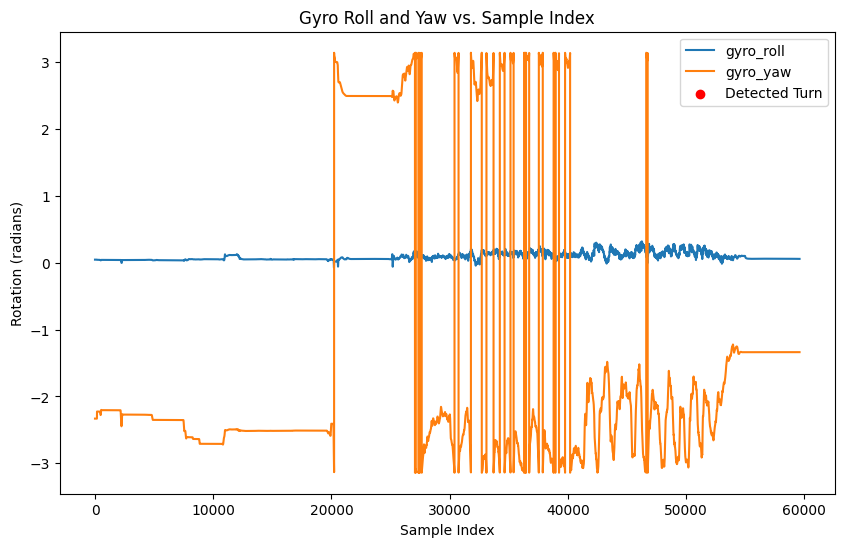

In [3]:


# 1.1) Convert Quaternion to Euler Angles (roll, pitch, yaw)

def quaternion_to_euler(w, x, y, z):
    """
    Convert a quaternion (w, x, y, z) to Euler angles (roll, pitch, yaw).
    All angles are in radians.
    """
    # Roll (x-axis rotation)
    roll = np.arctan2(2*(w*x + y*z), 1 - 2*(x*x + y*y))
    # Pitch (y-axis rotation)
    pitch = np.arcsin(2*(w*y - z*x))
    # Yaw (z-axis rotation)
    yaw = np.arctan2(2*(w*z + x*y), 1 - 2*(y*y + z*z))
    return roll, pitch, yaw

# Compute Euler angles for each row in the DataFrame
roll_list = []
yaw_list = []
for idx, row in df.iterrows():
    r, p, y = quaternion_to_euler(row['quat_w'], row['quat_x'], row['quat_y'], row['quat_z'])
    roll_list.append(r)
    yaw_list.append(y)

# Add computed roll and yaw as new columns
df["gyro_roll"] = roll_list
df["gyro_yaw"] = yaw_list

# 2) ACTION DETECTION

def detect_action_imu(roll_data, yaw_data, imu_threshold=0.5, window_size=5):
    """
    Simple sliding-window approach using the gyroscope (roll and yaw) signals.
    If the mean absolute rotation in the window exceeds imu_threshold,
    label the sample as 'active'; otherwise, 'inactive'.
    """
    action_labels = []
    half_win = window_size // 2

    # Pad the data arrays to allow a uniform window at the edges
    roll_pad = np.pad(roll_data, (half_win, half_win), mode='edge')
    yaw_pad  = np.pad(yaw_data,   (half_win, half_win), mode='edge')

    for i in range(len(roll_data)):
        r_segment = roll_pad[i : i + window_size]
        y_segment = yaw_pad[i : i + window_size]

        avg_gyro = np.mean(np.abs(r_segment)) + np.mean(np.abs(y_segment))

        if avg_gyro > imu_threshold:
            action_labels.append("active")
        else:
            action_labels.append("inactive")

    return action_labels

def detect_action_gps(gps_data, speed_threshold=0.5, window_size=5):
    """
    Simple sliding-window approach using the GPS speed.
    If the mean speed in the window exceeds speed_threshold,
    label the sample as 'active'; otherwise, 'inactive'.
    """
    action_labels = []
    half_win = window_size // 2
    gps_pad = np.pad(gps_data, (half_win, half_win), mode='edge')

    for i in range(len(gps_data)):
        seg = gps_pad[i : i + window_size]
        if np.mean(seg) > speed_threshold:
            action_labels.append("active")
        else:
            action_labels.append("inactive")

    return action_labels


# 3) PEAK DETECTION (Algorithm 1)

def detectPeaks(x, delta, band):
    """
    Implements Algorithm 1 from the paper.
    x     : 1D data array (e.g. gyro_roll or gyro_yaw)
    delta : minimal vertical difference to consider a peak
    band  : ignore peaks within +/- band (can be set to 0)
    Returns: (max_peaks, min_peaks) as lists of indices.
    """
    max_peaks = []
    min_peaks = []
    max_val = -np.inf
    min_val =  np.inf
    looking_for_max = True

    for i in range(len(x)):
        val = x[i]
        if val > max_val:
            max_val = val
        if val < min_val:
            min_val = val

        if looking_for_max:
            if val < (max_val - delta):
                if abs(max_val) > band:
                    idx_of_peak = i - 1
                    max_peaks.append(idx_of_peak)
                min_val = val
                looking_for_max = False
        else:
            if val > (min_val + delta):
                if abs(min_val) > band:
                    idx_of_peak = i - 1
                    min_peaks.append(idx_of_peak)
                max_val = val
                looking_for_max = True

    return max_peaks, min_peaks


# 4) TURN DETECTION (Algorithm 2)

def detectTurns(roll_data, yaw_data, delta=0.5, band=0.0, stance="regular"):
    """
    Detect turns using peaks in roll and yaw signals.
    Returns a list of detected turns. Each turn is a dictionary with:
       - 'time_index': index in the data array,
       - 'turn_label': one of ['NO_FS', 'NO_BS', 'SW_FS', 'SW_BS']
    The turn label is determined based on the combination of roll/yaw peaks
    and the rider's stance (regular or goofy).
    """
    roll_max, roll_min = detectPeaks(roll_data, delta, band)
    yaw_max,  yaw_min  = detectPeaks(yaw_data, delta, band)

    # Tag the peaks with their type and axis
    roll_peaks_all = [(idx, 'roll', 'max') for idx in roll_max] + \
                     [(idx, 'roll', 'min') for idx in roll_min]
    yaw_peaks_all  = [(idx, 'yaw', 'max') for idx in yaw_max] + \
                     [(idx, 'yaw', 'min') for idx in yaw_min]

    roll_peaks_all.sort(key=lambda x: x[0])
    yaw_peaks_all.sort(key=lambda x: x[0])

    turns = []

    # For each roll peak, find the nearest yaw peak and classify the turn.
    for r_idx, r_axis, r_type in roll_peaks_all:
        best_y = None
        best_dist = float('inf')
        for y_idx, y_axis, y_type in yaw_peaks_all:
            dist = abs(y_idx - r_idx)
            if dist < best_dist:
                best_dist = dist
                best_y = (y_idx, y_axis, y_type)

        if best_y is None:
            continue
        y_idx, y_axis, y_type = best_y

        # Classification based on Figure 9 from the paper:
        if r_type == 'min' and y_type == 'max':
            turn_label = "NO_FS" if stance == "regular" else "NO_BS"
        elif r_type == 'max' and y_type == 'min':
            turn_label = "NO_BS" if stance == "regular" else "NO_FS"
        elif r_type == 'min' and y_type == 'min':
            turn_label = "SW_FS" if stance == "regular" else "SW_BS"
        elif r_type == 'max' and y_type == 'max':
            turn_label = "SW_BS" if stance == "regular" else "SW_FS"
        else:
            continue

        turns.append({
            "time_index": r_idx,
            "turn_label": turn_label
        })

    turns.sort(key=lambda x: x["time_index"])
    return turns


# 5) EDGE & DIRECTION DETECTION

def infer_edge_direction(turns, stance="regular"):
    """
    Determines the edge (frontside/backside) and riding direction (normal/switch)
    for segments between detected turns.
    Returns a list of segments with start and end indices along with the inferred
    'edge' and 'direction' for each segment.
    """
    segments = []
    if not turns:
        return segments

    def parse_turn_label(lbl):
        # For a label like "NO_FS" or "SW_BS"
        normal_or_switch = "normal" if lbl.startswith("NO") else "switch"
        fs_or_bs = "frontside" if lbl.endswith("FS") else "backside"
        return normal_or_switch, fs_or_bs

    for i, trn in enumerate(turns):
        t_label = trn["turn_label"]
        t_idx   = trn["time_index"]
        direction, fsbs = parse_turn_label(t_label)

        if i == 0:
            # Deduce initial state from the first turn (using the opposite edge)
            if t_label == "NO_FS":
                init_edge = "backside"
                init_dir  = "normal"
            elif t_label == "NO_BS":
                init_edge = "frontside"
                init_dir  = "normal"
            elif t_label == "SW_FS":
                init_edge = "backside"
                init_dir  = "switch"
            elif t_label == "SW_BS":
                init_edge = "frontside"
                init_dir  = "switch"

            segments.append({
                "start_idx": 0,
                "end_idx": t_idx,
                "edge": init_edge,
                "direction": init_dir
            })
        else:
            prev_turn = turns[i-1]
            p_label = prev_turn["turn_label"]
            p_normal_or_switch, p_fsbs = parse_turn_label(p_label)
            segments.append({
                "start_idx": prev_turn["time_index"],
                "end_idx": t_idx,
                "edge": p_fsbs,
                "direction": p_normal_or_switch
            })

    # For the segment after the last turn:
    last_turn = turns[-1]
    lt_label  = last_turn["turn_label"]
    l_dir, l_fsbs = parse_turn_label(lt_label)
    segments.append({
        "start_idx": last_turn["time_index"],
        "end_idx": len(df) - 1,
        "edge": l_fsbs,
        "direction": l_dir
    })

    return segments


# 6) TECHNIQUE DETECTION (Algorithm 3)

def detectTechniques(turns, yaw_data, delta=0.2, band=0.0, cvs=5):
    """
    Detects whether the rider is carving or skidding between consecutive turns.
    Counts the small peaks in the yaw signal between turns. If the ratio (number
    of peaks)/(time interval) exceeds cvs, label as 'skidding'; otherwise, 'carving'.
    Returns a list (one entry per segment between turns).
    """
    y_max, y_min = detectPeaks(yaw_data, delta, band)
    all_y_peaks = sorted(y_max + y_min)

    if len(turns) < 2:
        return []

    techniques = []
    for i in range(len(turns) - 1):
        t_i = turns[i]["time_index"]
        t_i1 = turns[i+1]["time_index"]
        n_peaks = sum(1 for p in all_y_peaks if t_i < p < t_i1)
        tau = (t_i1 - t_i)  # in samples

        ratio = n_peaks / float(tau) if tau > 0 else 0
        if ratio > cvs:
            techniques.append("skidding")
        else:
            techniques.append("carving")

    return techniques


# 7) DEMO PIPELINE

# Extract our signals as numpy arrays
roll_data = df["gyro_roll"].values
yaw_data  = df["gyro_yaw"].values
gps_data  = df["gps_speed"].values if "gps_speed" in df.columns else None

# 7.1 Action detection using IMU data
action_labels_imu = detect_action_imu(roll_data, yaw_data, imu_threshold=0.5, window_size=5)
df["action_imu"] = action_labels_imu


if gps_data is not None:
    action_labels_gps = detect_action_gps(gps_data, speed_threshold=0.5, window_size=5)
    df["action_gps"] = action_labels_gps

# 7.2 Turn detection (tune delta and band as needed)
turns = detectTurns(roll_data, yaw_data, delta=0.5, band=0.0, stance="regular")

# 7.3 Edge and direction detection per segment
segments = infer_edge_direction(turns, stance="regular")

# 7.4 Technique detection (carving vs. skidding)
techniques = detectTechniques(turns, yaw_data, delta=0.2, band=0.0, cvs=5)
# Note: len(techniques) will be one less than the number of turns


# 8) OUTPUT / EXAMPLE USAGE

print("=== DETECTED ACTION (first 20 samples, IMU-based) ===")
print(df["action_imu"].head(20).values)

print("\n=== DETECTED TURNS (showing up to 10) ===")
for t in turns[:10]:
    print(t)

print("\n=== SEGMENTS: EDGE + DIRECTION ===")
for seg in segments[:5]:
    print(seg)

print("\n=== TECHNIQUES BETWEEN TURNS ===")
print(techniques[:5])


plt.figure(figsize=(10, 6))
plt.title("Gyro Roll and Yaw vs. Sample Index")
plt.plot(roll_data, label="gyro_roll")
plt.plot(yaw_data, label="gyro_yaw")

# Mark detected turns on the roll signal
turn_indices = [t["time_index"] for t in turns]
plt.scatter(turn_indices, roll_data[turn_indices], marker="o", color='red', label="Detected Turn", zorder=3)

plt.xlabel("Sample Index")
plt.ylabel("Rotation (radians)")
plt.legend()
plt.show()


=== TOTAL TURNS DETECTED ===
0

=== DETECTED TURNS (first 10 shown) ===

=== TECHNIQUE DETECTION (between consecutive turns) ===
Techniques detected: []


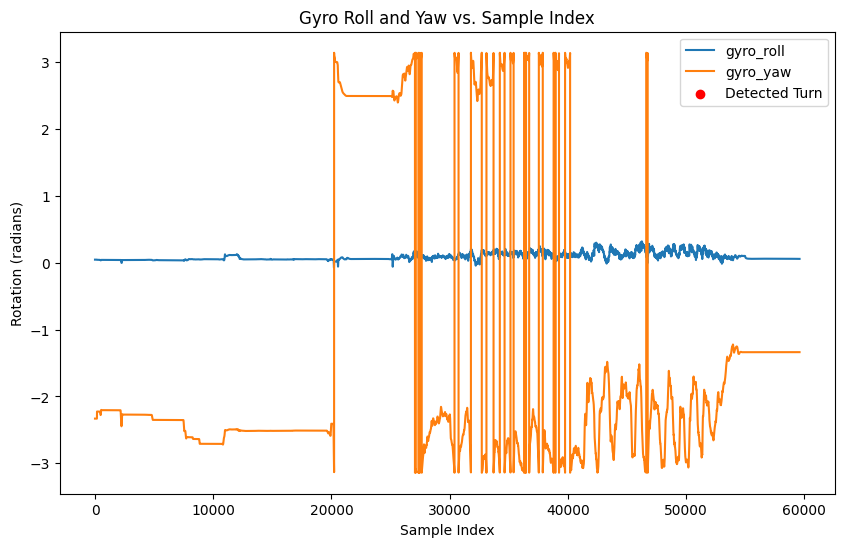

In [2]:

# 1.1) Convert Quaternion to Euler Angles (roll, pitch, yaw)

def quaternion_to_euler(w, x, y, z):
    """
    Convert a quaternion (w, x, y, z) to Euler angles (roll, pitch, yaw).
    All angles are in radians.
    """
    roll = np.arctan2(2*(w*x + y*z), 1 - 2*(x*x + y*y))
    pitch = np.arcsin(2*(w*y - z*x))
    yaw = np.arctan2(2*(w*z + x*y), 1 - 2*(y*y + z*z))
    return roll, pitch, yaw

roll_list = []
yaw_list = []
for idx, row in df.iterrows():
    r, p, y = quaternion_to_euler(row['quat_w'], row['quat_x'], row['quat_y'], row['quat_z'])
    roll_list.append(r)
    yaw_list.append(y)

df["gyro_roll"] = roll_list
df["gyro_yaw"] = yaw_list

# 2) ACTION DETECTION

def detect_action_imu(roll_data, yaw_data, imu_threshold=0.5, window_size=5):
    action_labels = []
    half_win = window_size // 2
    roll_pad = np.pad(roll_data, (half_win, half_win), mode='edge')
    yaw_pad  = np.pad(yaw_data, (half_win, half_win), mode='edge')
    for i in range(len(roll_data)):
        r_segment = roll_pad[i : i + window_size]
        y_segment = yaw_pad[i : i + window_size]
        avg_gyro = np.mean(np.abs(r_segment)) + np.mean(np.abs(y_segment))
        action_labels.append("active" if avg_gyro > imu_threshold else "inactive")
    return action_labels

def detect_action_gps(gps_data, speed_threshold=0.5, window_size=5):
    action_labels = []
    half_win = window_size // 2
    gps_pad = np.pad(gps_data, (half_win, half_win), mode='edge')
    for i in range(len(gps_data)):
        seg = gps_pad[i : i + window_size]
        action_labels.append("active" if np.mean(seg) > speed_threshold else "inactive")
    return action_labels


# 3) PEAK DETECTION (Algorithm 1)

def detectPeaks(x, delta, band):
    max_peaks = []
    min_peaks = []
    max_val = -np.inf
    min_val =  np.inf
    looking_for_max = True
    for i in range(len(x)):
        val = x[i]
        if val > max_val:
            max_val = val
        if val < min_val:
            min_val = val
        if looking_for_max:
            if val < (max_val - delta):
                if abs(max_val) > band:
                    max_peaks.append(i - 1)
                min_val = val
                looking_for_max = False
        else:
            if val > (min_val + delta):
                if abs(min_val) > band:
                    min_peaks.append(i - 1)
                max_val = val
                looking_for_max = True
    return max_peaks, min_peaks

# 4) TURN DETECTION (Algorithm 2)

def detectTurns(roll_data, yaw_data, delta=0.5, band=0.0, stance="regular"):
    roll_max, roll_min = detectPeaks(roll_data, delta, band)
    yaw_max,  yaw_min  = detectPeaks(yaw_data, delta, band)
    roll_peaks_all = [(idx, 'roll', 'max') for idx in roll_max] + [(idx, 'roll', 'min') for idx in roll_min]
    yaw_peaks_all  = [(idx, 'yaw', 'max') for idx in yaw_max] + [(idx, 'yaw', 'min') for idx in yaw_min]
    roll_peaks_all.sort(key=lambda x: x[0])
    yaw_peaks_all.sort(key=lambda x: x[0])

    turns = []
    for r_idx, r_axis, r_type in roll_peaks_all:
        best_y = None
        best_dist = float('inf')
        for y_idx, y_axis, y_type in yaw_peaks_all:
            dist = abs(y_idx - r_idx)
            if dist < best_dist:
                best_dist = dist
                best_y = (y_idx, y_axis, y_type)
        if best_y is None:
            continue
        y_idx, y_axis, y_type = best_y
        if r_type == 'min' and y_type == 'max':
            turn_label = "NO_FS" if stance == "regular" else "NO_BS"
        elif r_type == 'max' and y_type == 'min':
            turn_label = "NO_BS" if stance == "regular" else "NO_FS"
        elif r_type == 'min' and y_type == 'min':
            turn_label = "SW_FS" if stance == "regular" else "SW_BS"
        elif r_type == 'max' and y_type == 'max':
            turn_label = "SW_BS" if stance == "regular" else "SW_FS"
        else:
            continue
        turns.append({"time_index": r_idx, "turn_label": turn_label})
    turns.sort(key=lambda x: x["time_index"])
    return turns

# 5) EDGE & DIRECTION DETECTION

def infer_edge_direction(turns, stance="regular"):
    segments = []
    if not turns:
        return segments

    def parse_turn_label(lbl):
        normal_or_switch = "normal" if lbl.startswith("NO") else "switch"
        fs_or_bs = "frontside" if lbl.endswith("FS") else "backside"
        return normal_or_switch, fs_or_bs

    for i, trn in enumerate(turns):
        t_label = trn["turn_label"]
        t_idx   = trn["time_index"]
        direction, fsbs = parse_turn_label(t_label)
        if i == 0:
            if t_label == "NO_FS":
                init_edge = "backside"
                init_dir  = "normal"
            elif t_label == "NO_BS":
                init_edge = "frontside"
                init_dir  = "normal"
            elif t_label == "SW_FS":
                init_edge = "backside"
                init_dir  = "switch"
            elif t_label == "SW_BS":
                init_edge = "frontside"
                init_dir  = "switch"
            segments.append({"start_idx": 0, "end_idx": t_idx, "edge": init_edge, "direction": init_dir})
        else:
            prev_turn = turns[i-1]
            p_label = prev_turn["turn_label"]
            p_normal_or_switch, p_fsbs = parse_turn_label(p_label)
            segments.append({"start_idx": prev_turn["time_index"], "end_idx": t_idx, "edge": p_fsbs, "direction": p_normal_or_switch})

    last_turn = turns[-1]
    lt_label  = last_turn["turn_label"]
    l_dir, l_fsbs = parse_turn_label(lt_label)
    segments.append({"start_idx": last_turn["time_index"], "end_idx": len(df) - 1, "edge": l_fsbs, "direction": l_dir})

    return segments

# 6) TECHNIQUE DETECTION (Algorithm 3)

def detectTechniques(turns, yaw_data, delta=0.2, band=0.0, cvs=5):
    y_max, y_min = detectPeaks(yaw_data, delta, band)
    all_y_peaks = sorted(y_max + y_min)

    if len(turns) < 2:
        return []

    techniques = []
    for i in range(len(turns) - 1):
        t_i = turns[i]["time_index"]
        t_i1 = turns[i+1]["time_index"]
        n_peaks = sum(1 for p in all_y_peaks if t_i < p < t_i1)
        tau = (t_i1 - t_i)
        ratio = n_peaks / float(tau) if tau > 0 else 0
        techniques.append("skidding" if ratio > cvs else "carving")

    return techniques


roll_data = df["gyro_roll"].values
yaw_data  = df["gyro_yaw"].values
gps_data  = df["gps_speed"].values if "gps_speed" in df.columns else None

# Action detection using IMU data
action_labels_imu = detect_action_imu(roll_data, yaw_data, imu_threshold=0.5, window_size=5)
df["action_imu"] = action_labels_imu


if gps_data is not None:
    action_labels_gps = detect_action_gps(gps_data, speed_threshold=0.5, window_size=5)
    df["action_gps"] = action_labels_gps

# Turn detection (tune delta and band as needed)
turns = detectTurns(roll_data, yaw_data, delta=0.5, band=0.0, stance="regular")

# Edge and direction detection per segment
segments = infer_edge_direction(turns, stance="regular")

# Technique detection (carving vs. skidding)
techniques = detectTechniques(turns, yaw_data, delta=0.2, band=0.0, cvs=5)


print("=== TOTAL TURNS DETECTED ===")
print(len(turns))

print("\n=== DETECTED TURNS (first 10 shown) ===")
for t in turns[:10]:
    print(t)

print("\n=== TECHNIQUE DETECTION (between consecutive turns) ===")
print("Techniques detected:", techniques)


plt.figure(figsize=(10, 6))
plt.title("Gyro Roll and Yaw vs. Sample Index")
plt.plot(roll_data, label="gyro_roll")
plt.plot(yaw_data, label="gyro_yaw")
turn_indices = [t["time_index"] for t in turns]
plt.scatter(turn_indices, roll_data[turn_indices], marker="o", color='red', label="Detected Turn", zorder=3)
plt.xlabel("Sample Index")
plt.ylabel("Rotation (radians)")
plt.legend()
plt.show()

In [ ]:
# === STEP 1: Yaw Rate Estimation ===
fs = 100  # Sampling rate (Hz)
dt = 1.0 / fs
df["yaw_rate"] = np.gradient(df["gyro_yaw"], dt)


In [ ]:
# === STEP 2: Detect Trick Landings (Spin bursts + GPS dip) ===
def detect_air_events_quat(yaw_rate, gps_speed, fs, yaw_thresh_deg=200, speed_dip=0.8):
    spin_mask = np.abs(np.rad2deg(yaw_rate)) > yaw_thresh_deg
    mean_speed = pd.Series(gps_speed).rolling(10, min_periods=1).mean()
    speed_mask = gps_speed < mean_speed * speed_dip
    candidates = np.where(spin_mask & speed_mask)[0]
    impacts, current = [], []
    for i in candidates:
        if current and i == current[-1] + 1:
            current.append(i)
        else:
            if current: impacts.append(current[-1])
            current = [i]
    if current: impacts.append(current[-1])
    return impacts

impacts = detect_air_events_quat(df["yaw_rate"].values, df["gps_speed"].values, fs)
print("Detected Trick Landings:", impacts)


In [ ]:
# === STEP 3: Integrate Spin and Assign Spin Label ===
def integrate_spin(gyro_z, impact_idx, fs, lookback_s=2.0):
    start = max(0, impact_idx - int(lookback_s * fs))
    total_rad = np.sum(gyro_z[start:impact_idx]) * (1/fs)
    return np.rad2deg(total_rad)

def label_spin(total_deg, tol=40):
    spins = np.array([0, 180, 360, 540, 720, 900, 1080, 1260])
    nearest = spins[np.argmin(np.abs(spins - np.abs(total_deg)))]
    return "unknown" if abs(total_deg - nearest) > tol else f"{nearest}-spin"

# Detect tricks and store
trick_events = []
for idx in impacts:
    spin_deg = integrate_spin(df["yaw_rate"].values, idx, fs)
    label = label_spin(spin_deg)
    trick_events.append({
        "impact_index": idx,
        "spin_deg": spin_deg,
        "spin_label": label
    })

trick_df = pd.DataFrame(trick_events)
print(trick_df.head())


In [ ]:
# === STEP 4: Plot Trick Landings ===
plt.figure(figsize=(12, 6))
plt.plot(df["gyro_yaw"], label="Yaw (rad)")
plt.plot(df["yaw_rate"], label="Yaw Rate (rad/s)")
for ev in trick_events:
    plt.axvline(ev["impact_index"], color='red', linestyle='--')
plt.legend()
plt.title("Yaw and Detected Trick Landings")
plt.xlabel("Sample Index")
plt.ylabel("Angle / Angular Velocity")
plt.grid(True)
plt.tight_layout()
plt.show()
